In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdDepictor
from rdkit.Chem import Draw
from rdkit.Chem import RDConfig
from rdkit.Chem import FragmentCatalog
from rdkit.Chem.Draw import IPythonConsole
rdDepictor.SetPreferCoordGen(True)
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

In [3]:
def attr2tag(attr):
    if attr < 0:
        return -1
    else:
        return 1

In [3]:
pred = pd.read_csv('../predictions/tg_pred.csv')

for index in range(0, len(pred), 4):
    pred.at[index, 'Importance'] = pred.at[index, 'tg'] - pred.at[index, 'tg']
    pred.at[index+1, 'Importance'] = pred.at[index, 'tg'] - pred.at[index+1, 'tg']
    pred.at[index+2, 'Importance'] = pred.at[index, 'tg'] - pred.at[index+2, 'tg']
    pred.at[index+3, 'Importance'] = pred.at[index, 'tg'] - pred.at[index+3, 'tg']
    pred.at[index, 'sub'] = pred.at[index, 'SMILES']
    pred.at[index+1, 'sub'] = pred.at[index, 'SMILES_1']
    pred.at[index+2, 'sub'] = pred.at[index, 'SMILES_2']
    pred.at[index+3, 'sub'] = pred.at[index, 'SMILES_3']

In [4]:
# data表示数据集中出现的每个子结构以及对应的重要性
data = pred[['sub', 'Importance']]
data = data[data['Importance'] != 0]

In [5]:
sub_name_list = data['sub'].tolist()

for sub_name in sub_name_list:
    if len(data[data['sub']==sub_name]) <= 8: # 找出出现9次及以上的子结构
        data = data[data['sub']!=sub_name]


tag_list = [attr2tag(x) for x in data['Importance'].tolist()]
data['tag'] = tag_list

# 将data按照diff进行排序
data = data.sort_values(by='Importance', ascending=True)

In [6]:
sub_name_set = set(data['sub'].tolist())

sub_atrr_average = {}

for sub_name in sub_name_set:
    sub_data = data[data['sub']==sub_name]
    sub_atrr_average[sub_name] = sub_data['Importance'].mean()



summary_data = pd.DataFrame.from_dict(sub_atrr_average, orient='index', columns=['importance'])
summary_data = summary_data.reset_index().rename(columns={'index':'sub'})
summary_data = summary_data.sort_values(by='importance', ascending=True)
summary_data = summary_data.reset_index(drop=True)
filter_sub_name_list = summary_data['sub'].tolist()

In [9]:
# colors = sns.color_palette('pastel6', 2)
fig = plt.figure(figsize=(17, 15), dpi=500)
sns.set_theme(font_scale=1.8, style='ticks')

atribution_x_cor=-55


g = sns.stripplot(y='sub', x='Importance', hue='tag', data=data
                  , alpha=0.8, size=6, dodge=True, palette=['#3b74a7', '#bb505c'], order=filter_sub_name_list,
                  linewidth=0.1)

# g = sns.violinplot(y='sub', x='Attribution', hue='attribution_tag',
#                    data=data, order=filter_sub_name_list, split=True, inner='quartile', density_norm='width',
#                    palette=['b', 'r'])



g = sns.boxplot(y='sub', x='Importance', data=data, order=filter_sub_name_list, showfliers=False, hue='tag',
                palette=['#4ac1e4', '#f08430'], boxprops=dict(alpha=0.95), linewidth=2)

# g.set_yticklabels([])  # 设置y轴标签为空值

g.text(atribution_x_cor, -0.8,  'Average \n Importance', color="Black",  ha="center")
g.set_xlim(-60, 50)

for index, row in summary_data.iterrows():
    if row.importance <= 0:
        g.text(atribution_x_cor, index+0.1, round(row.importance, 2), color="b",  ha="center")
    else:
        g.text(atribution_x_cor, index+0.1, round(row.importance, 2), color="r",  ha="center")

plt.legend([],[], frameon=False)

font2 = {'weight' : 'normal',
        'size'   : 25,
        }
plt.ylabel('Substructures', font2)
plt.xlabel('Importance', font2)
plt.axvline(0, color="black", linestyle = '--', alpha = 0.8) #竖线

for i in range(9):
    g.patches[i].set_edgecolor('#003285')
    g.patches[i].set_linewidth(1.5)

for i in range(9, len(g.patches)):
    g.patches[i].set_edgecolor('#952323')
    g.patches[i].set_linewidth(1.5)

negatvie_x = 25
positive_x = -25

# 在plot中加上分子图
for index, row in summary_data.iterrows():
    if row.importance <= 0:
        mol = Chem.MolFromSmiles(row['sub'])
        rdDepictor.Compute2DCoords(mol)
        d2d = Draw.MolDraw2DCairo(100,50)
        d2d.drawOptions().setBackgroundColour((1,1,1,0))
        d2d.drawOptions().useBWAtomPalette()
        d2d.DrawMolecule(mol)
        img = Draw._drawerToImage(d2d)
        imagebox = OffsetImage(np.asarray(img), zoom = .75)
        pos = (negatvie_x, index)
        ab = AnnotationBbox(imagebox, pos, frameon = False)
        fig.axes[0].add_artist(ab)
    else:
        mol = Chem.MolFromSmiles(row['sub'])
        rdDepictor.Compute2DCoords(mol)
        d2d = Draw.MolDraw2DCairo(130,80)
        d2d.drawOptions().setBackgroundColour((1,1,1,0))
        d2d.drawOptions().useBWAtomPalette()
        d2d.DrawMolecule(mol)
        img = Draw._drawerToImage(d2d)
        imagebox = OffsetImage(np.asarray(img), zoom = .75)
        pos = (positive_x, index)
        ab = AnnotationBbox(imagebox, pos, frameon = False)
        fig.axes[0].add_artist(ab)

In [11]:
fName=os.path.join(RDConfig.RDDataDir,'FunctionalGroups.txt')
fparams = FragmentCatalog.FragCatParams(1,6,fName)
fg_list = [fparams.GetFuncGroup(i) for i in range(fparams.GetNumFuncGroups())]
fg_name_list = [fg.GetProp('_Name') for fg in fg_list]

def convert_fg_name(smi, fg_list):
    if smi == 'Cl' or smi == 'Br' or smi == 'F':
        return "-X"

    for fg in fg_list:
        if smi == Chem.MolToSmiles(fg):
            return fg.GetProp('_Name')

In [13]:
pred = pd.read_csv('../predictions/tg_pred_fg.csv')

for index in range(0, len(pred), 4):
    pred.at[index, 'Importance'] = pred.at[index, 'tg'] - pred.at[index, 'tg']
    pred.at[index+1, 'Importance'] = pred.at[index, 'tg'] - pred.at[index+1, 'tg']
    pred.at[index+2, 'Importance'] = pred.at[index, 'tg'] - pred.at[index+2, 'tg']
    pred.at[index+3, 'Importance'] = pred.at[index, 'tg'] - pred.at[index+3, 'tg']
    pred.at[index, 'sub'] = pred.at[index, 'SMILES']
    pred.at[index+1, 'sub'] = pred.at[index, 'SMILES_1']
    pred.at[index+2, 'sub'] = pred.at[index, 'SMILES_2']
    pred.at[index+3, 'sub'] = pred.at[index, 'SMILES_3']


data = pred[['sub', 'Importance']]
data = data[data['Importance'] != 0]
data = data[data['sub'] != "*"]

sub_name_list = data['sub'].tolist()

for sub_name in sub_name_list:
    if len(data[data['sub']==sub_name]) <= 1:
        data = data[data['sub']!=sub_name]


tag_list = [attr2tag(x) for x in data['Importance'].tolist()]
data['tag'] = tag_list

# 将data按照diff进行排序
data = data.sort_values(by='Importance', ascending=True)

for index, row in data.iterrows():
    data.at[index, 'sub'] = convert_fg_name(row['sub'], fg_list)

In [14]:
sub_name_set = set(data['sub'].tolist())

sub_atrr_average = {}

for sub_name in sub_name_set:
    sub_data = data[data['sub']==sub_name]
    sub_atrr_average[sub_name] = sub_data['Importance'].mean()



summary_data = pd.DataFrame.from_dict(sub_atrr_average, orient='index', columns=['average'])
summary_data = summary_data.reset_index().rename(columns={'index':'sub'})
summary_data = summary_data.sort_values(by='average', ascending=True)
summary_data = summary_data.reset_index(drop=True)
filter_sub_name_list = summary_data['sub'].tolist()

In [16]:
def name2mol(sub):
    for fg in fg_list:
        if sub == fg.GetProp('_Name'):
            return fg

summary_data['mol'] = summary_data['sub'].apply(name2mol)

In [48]:
# colors = sns.color_palette('tab10', 2)
fig = plt.figure(figsize=(17, 15), dpi=500)
sns.set_theme(font_scale=1.8, style='ticks')

atribution_x_cor=-55



g = sns.stripplot(y='sub', x='Importance', hue='tag', data=data
                  , alpha=0.8, size=6, dodge=True, palette=['#3b74a7', '#bb505c'], order=filter_sub_name_list)
g = sns.boxplot(y='sub', x='Importance', data=data, order=filter_sub_name_list, showfliers=False, hue='tag',
                palette=['#4ac1e4', '#f08430'], boxprops=dict(alpha=0.95), linewidth=2)
g.text(atribution_x_cor, -0.8,  'Average \n Importance', color="Black",  ha="center")
g.set_xlim(-60, 50)

for index, row in summary_data.iterrows():
    if row.average <= 0:
        g.text(atribution_x_cor, index+0.1, round(row.average, 2), color="b",  ha="center")
    else:
        g.text(atribution_x_cor, index+0.1, round(row.average, 2), color="r",  ha="center")

plt.legend([],[], frameon=False)

font2 = {'weight' : 'normal',
        'size'   : 25,
        }
plt.ylabel('Functional Group', font2)
plt.xlabel('Importance', font2)
plt.axvline(0, color="black", linestyle = '--', alpha = 0.8) #竖线


for i in range(3):
    g.patches[i].set_edgecolor('#003285')
    g.patches[i].set_linewidth(1.5)

for i in range(3, len(g.patches)):
    g.patches[i].set_edgecolor('#952323')
    g.patches[i].set_linewidth(1.5)


g.patches[3].set_edgecolor('#003285')
g.patches[3].set_linewidth(1.5)

g.patches[4].set_edgecolor('#003285')
g.patches[4].set_linewidth(1.5)

negatvie_x = 25
positive_x = -25



# 在plot中加上分子图
for index, row in summary_data.iterrows():
    if row.average <= 0:
        mol = row['mol']
        rdDepictor.Compute2DCoords(mol)
        d2d = Draw.MolDraw2DCairo(100,50)
        d2d.drawOptions().setBackgroundColour((1,1,1,0))
        d2d.drawOptions().useBWAtomPalette()
        d2d.DrawMolecule(mol)
        img = Draw._drawerToImage(d2d)
        imagebox = OffsetImage(np.asarray(img), zoom = .75)
        pos = (negatvie_x, index)
        ab = AnnotationBbox(imagebox, pos, frameon = False)
        fig.axes[0].add_artist(ab)
    else:
        mol = row['mol']
        rdDepictor.Compute2DCoords(mol)
        d2d = Draw.MolDraw2DCairo(130,80)
        d2d.drawOptions().setBackgroundColour((1,1,1,0))
        d2d.drawOptions().useBWAtomPalette()
        d2d.DrawMolecule(mol)
        img = Draw._drawerToImage(d2d)
        imagebox = OffsetImage(np.asarray(img), zoom = .75)
        pos = (positive_x, index)
        ab = AnnotationBbox(imagebox, pos, frameon = False)
        fig.axes[0].add_artist(ab)

---
判断两个SMILES字符串是否是同一分子

数据格式

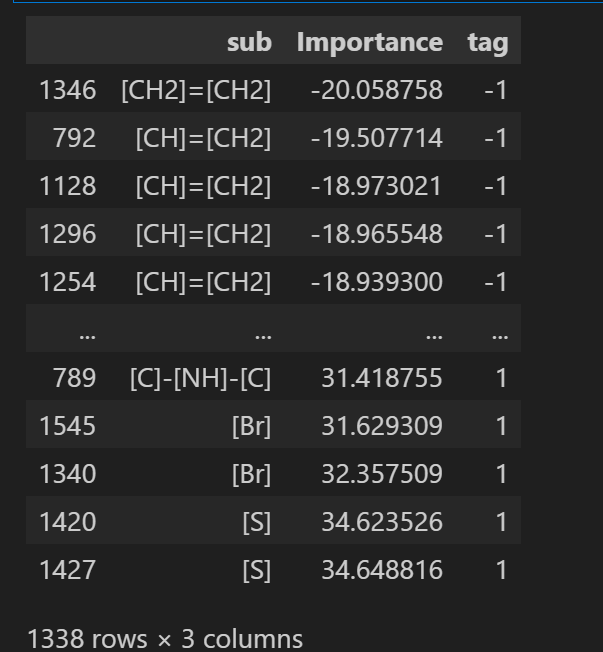

In [ ]:
from rdkit import Chem

def is_same_molecule(smiles1, smiles2):
    # 将SMILES字符串转换为分子对象
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    # 检查分子对象是否成功生成
    if mol1 is None or mol2 is None:
        raise ValueError("其中一个或两个SMILES字符串无效")
    
    # 比较两个分子的标准化形式
    return Chem.MolToSmiles(mol1, canonical=True) == Chem.MolToSmiles(mol2, canonical=True)


# 两两标准化SMILES（其实不是标准化，而是选择某一个SMILES字符串作为标准）
def unify_smiles(df):
    # 用于存储标准化后的SMILES
    canonical_smiles_map = {}

    # 遍历数据框中的每一对SMILES
    for i, row_i in df.iterrows():
        smiles_i = row_i['sub']
        if smiles_i not in canonical_smiles_map:
            canonical_smiles_map[smiles_i] = smiles_i
        
        for j, row_j in df.iterrows():
            if i != j:
                smiles_j = row_j['sub']
                if is_same_molecule(smiles_i, smiles_j):
                    canonical_smiles_map[smiles_j] = canonical_smiles_map[smiles_i]

    # 将没有匹配到的SMILES也添加到映射中
    for smiles in df['sub']:
        if smiles not in canonical_smiles_map:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                canonical_smiles_map[smiles] = smiles
    
    # 使用标准化后的SMILES替换原始的SMILES
    df['sub'] = df['sub'].map(canonical_smiles_map)
    
    return df
